In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
import math
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
biometrics_df = pd.read_csv("../1_standarized_biometrics.csv")
biometrics_df.head()

,HR,HRV,MicroSiemens,ArousalMean
0,-0.255155,-1.609745,-1.658083,0.0
1,0.427759,-1.627232,-1.646859,0.0
2,-0.088221,-1.627232,-1.658083,0.0
3,-0.133748,-1.627232,-1.658083,0.0
4,-0.224803,-1.443622,-1.669307,0.0


In [3]:
X = biometrics_df[['MicroSiemens', 'HR', 'HRV' ]].values
y = biometrics_df['ArousalMean'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [5]:
# Para poder usar un clasificador, los datos de la variable target deben ser discretos.
#Los convertimos a True-False (Aroused-NotAroused) con el fin de poder entrear un clasificador binario
def map_to_0_and_1(arousal):
    return 0 if arousal < 5 else 1

y_train_aroused = np.array(list(map(map_to_0_and_1, y_train)))
y_test_aroused = np.array(list(map(map_to_0_and_1, y_test)))

In [6]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train_aroused)

KNeighborsClassifier()

# Prediction

In [7]:
knn.predict(X[145].reshape(1, -1))

array([0])

# TRAIN Performance Measuring

In [8]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Cross Validation \t")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))        
        
        res = cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy')
        print("Cross Validation \t")
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

In [9]:
print_score(knn, X_train, y_train_aroused, X_test, y_test_aroused, train=True)

Train Result:

Accuracy score: 0.8355

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      2155
           1       0.75      0.68      0.71       908

    accuracy                           0.84      3063
   macro avg       0.81      0.79      0.80      3063
weighted avg       0.83      0.84      0.83      3063


Confusion Matrix: 
 [[1945  210]
 [ 294  614]]

Cross Validation 	
Average Accuracy: 	 0.6128
Accuracy SD: 		 0.0586


In [10]:
print_score(knn, X_train, y_train_aroused, X_test, y_test_aroused, train=False)

Test Result:

accuracy score: 0.5196

Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.76      0.61       379
           1       0.55      0.29      0.38       387

    accuracy                           0.52       766
   macro avg       0.53      0.52      0.49       766
weighted avg       0.53      0.52      0.49       766


Confusion Matrix: 
 [[287  92]
 [276 111]]

Cross Validation 	
Average Accuracy: 	 0.6295
Accuracy SD: 		 0.1459


# Grid Search

In [11]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [12]:
params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [13]:
grid_search_cv = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, verbose=1)

In [14]:
grid_search_cv.fit(X_train, y_train_aroused)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=1)

In [15]:
grid_search_cv.best_estimator_

KNeighborsClassifier(n_neighbors=2)

In [16]:
y_test_pred_grid = grid_search_cv.predict(X_test)

In [17]:
print_score(grid_search_cv, X_train, y_train_aroused, X_test, y_test_aroused, train=True)

Train Result:

Accuracy score: 0.8740

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      2155
           1       1.00      0.57      0.73       908

    accuracy                           0.87      3063
   macro avg       0.92      0.79      0.82      3063
weighted avg       0.89      0.87      0.86      3063


Confusion Matrix: 
 [[2155    0]
 [ 386  522]]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation 	
Average Accuracy: 	 0.6448
Accuracy SD: 		 0.0443


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [18]:
print_score(grid_search_cv, X_train, y_train_aroused, X_test, y_test_aroused, train=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Test Result:

accuracy score: 0.4987

Classification Report: 
               precision    recall  f1-score   support

           0       0.50      0.85      0.63       379
           1       0.51      0.16      0.24       387

    accuracy                           0.50       766
   macro avg       0.50      0.50      0.43       766
weighted avg       0.50      0.50      0.43       766


Confusion Matrix: 
 [[321  58]
 [326  61]]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Cross Validation 	
Average Accuracy: 	 0.6320
Accuracy SD: 		 0.1388


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [19]:
grid_search_cv.best_params_

{'n_neighbors': 2}

In [20]:
# grid_search_cv.cv_results_['mean_train_score']

In [21]:
grid_search_cv.cv_results_

{'mean_fit_time': array([0.00183401, 0.00193958, 0.00185752, 0.00174217, 0.00160699,
        0.00157061, 0.00148206, 0.00148993, 0.00143275, 0.00135407]),
 'std_fit_time': array([5.55079416e-05, 9.09555349e-05, 2.36612296e-04, 2.66634275e-05,
        1.31192921e-04, 4.08384233e-05, 3.14641713e-05, 4.76652109e-05,
        9.35120827e-05, 1.21499624e-04]),
 'mean_score_time': array([0.03895497, 0.03803496, 0.03518291, 0.03742914, 0.0365499 ,
        0.03495903, 0.03283396, 0.03211627, 0.02650332, 0.02186694]),
 'std_score_time': array([0.00457033, 0.00462768, 0.00247968, 0.00101627, 0.00230148,
        0.00334553, 0.00158645, 0.00312206, 0.00236298, 0.00277586]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 

In [22]:
df_y_train = pd.DataFrame(data=y_test_aroused, columns=['Arousal'])
df_y_pred = pd.DataFrame(data=y_test_pred_grid, columns=['Arousal'])

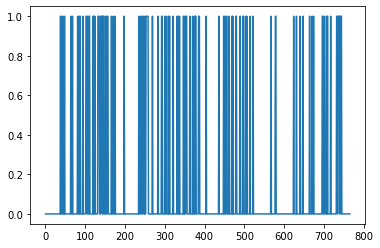

In [23]:
plt.plot(df_y_pred["Arousal"])
plt.show()

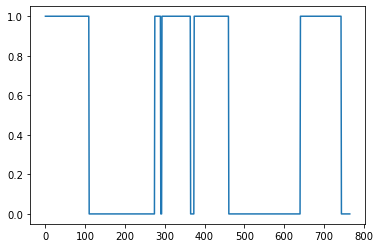

In [24]:
plt.plot(df_y_train["Arousal"])
plt.show()

In [25]:
import pickle

# save the model to disk
pickle.dump(grid_search_cv, open('../models/knn-hr-skin-model', 'wb'))
print('Done')

FileNotFoundError: [Errno 2] No such file or directory: '../models/knn-hr-skin-model'